In [5]:
import numpy
import h5py
from sklearn.model_selection import train_test_split
import pickle
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from numpy.random import normal
from sklearn.neural_network import MLPClassifier

In [2]:
def sigmoid(z):
    return (1.0/(1.0 + numpy.exp(-1*z)))

def sigmoid_derivative(z):
    return z*(1-z)


def softmax(z):
    exp_z = numpy.exp(z)
    return exp_z/exp_z.sum()

In [3]:
def update_weights(weights, bias, delta_weights, delta_biases, learning_rate):    
    
    for i in range(len(weights)):     
        
        change_weight = delta_weights[-1*i - 1]
        change = numpy.multiply(change_weight, learning_rate)
        weights[i] = weights[i] - change
        chamge_bias = delta_biases[-1*i - 1]
        change = numpy.multiply(chamge_bias, learning_rate)
        bias[i] = bias[i] - change

    return weights, bias

In [9]:
def forward_prop(input_vector, weights, bias):
    
    #num_layers is total layers
    num_layers = len(weights) + 1 
    layer_output = [0]*(num_layers)
    input_vector = numpy.reshape(input_vector, (len(input_vector), 1))
    #     print("input vector shape" , input_vector.shape)
    weights = numpy.array(weights)

    layer_output[0] = input_vector
    for i in range(num_layers-1):
        z = numpy.dot(weights[i].T, input_vector) + bias[i]
        if (i != len(weights) - 1):
            output_data = sigmoid(z)
        else:
            output_data = softmax(z)
        input_vector = output_data
        layer_output[i+1] = output_data
    
#     layer_output[num_layers - 1] = softmax(output_data)
#     print("forw len",len(layer_output))
    return (layer_output)
#         output_data = sigmoid(numpy.dot(weights[i].T, input_vector) + bias[i])
#         input_vector = output_data
#         layer_output[i+1] = output_data

#     #layer_output[num_layers - 1] = softmax(output_data)
# #     print("forw len",len(layer_output))
#     return (layer_output)

In [4]:
def backward_prop(weights, bias, layer_output, encoded_y):
#     len(layer_output) 
    count = 0
    delta = [] 
    delta_weights = []
    delta_biases = []
#     print("length", len(layer_output))
    for i in range(len(layer_output) - 1, 0, -1):
        if (i == len(layer_output) - 1):  #softmax
            encoded_y = numpy.reshape(encoded_y, (2, 1))
            error = layer_output[i] - encoded_y
#             print("shape check" , layer_output[i].shape, encoded_y.shape)
#             print(error.shape)
            delta.append(error)
            mul =  numpy.dot(layer_output[i - 1], error.T)
#             print(delta_w.shape)
            delta_biases.append(error)
            delta_weights.append(mul)
#             print(delta_b.shape)
        else:
            if (len(layer_output[i].shape) == 1):
                layer_output[i] = numpy.expand_dims(layer_output[i], axis = 0)
#                 print("if condition ran")
            mul = numpy.dot(layer_output[-(count+2)], error.T)
            delta_weights.append(mul)
        
            error = numpy.dot(weights[-1*count], delta[-1]) * sigmoid_derivative(layer_output[i])
            delta.append(error)
            
            delta_biases.append(error)
#             print("ELSE CHALAA")
    
        count+=1
        
    return delta_weights, delta_biases, encoded_y

In [6]:
with h5py.File('MNIST_Subset.h5', 'r') as dataH5:
    features = numpy.array(list(dataH5['X']))    
    labels = numpy.array(list(dataH5['Y']))

features = numpy.reshape(features, (14251, 784))
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2)

In [7]:
encoded_y = numpy.zeros((len(y_train),2))
#                         [[0]*2]*(len(y_train))
for i in range(len(y_train)):
    if (y_train[i] == 7):
        encoded_y[i][0] = 1
    else:
        encoded_y[i][1] = 1        
# print(count, count2)        
print(encoded_y.shape)

(11400, 2)


In [42]:
#num_layers is the number of hidden layers
learning_rate = 0.1
weights = []
bias = []
num_layers = 5
num_nodes = [784, 100, 100, 50, 2]

#random weights initialization
for i in range(num_layers-1):
    weights.append(numpy.random.normal(0, 0.1, (num_nodes[i], num_nodes[i+1])))
    bias.append(numpy.random.normal(0, 0.1, (num_nodes[i+1], 1)))

layer_output = [0]*(num_layers)
input_data = x_train
delta_array = []
flag = 0
epochs = 50
batch_size = 20
weights = numpy.array(weights)
train_accuracy = []
test_accuracy = []
for i in range(epochs):
    for j in range(len(x_train)):
        layer_output = forward_prop(x_train[j], weights, bias)
#         print("check", len(layer_output))
        if (flag == 0):
            delta_weights, delta_biases, y = backward_prop(weights, bias, layer_output, encoded_y[j])
            del_weigh = delta_weights
            del_bia = delta_biases
#             print("back called")
            flag = 1
        else:
            delta_weights, delta_biases, y = backward_prop(weights, bias, layer_output, encoded_y[j])
#             print("else executed")

            for k in range(len(delta_weights)):
                old_delta = del_weigh[k]
                new_delta = delta_weights[k]
                del_weigh[k] = numpy.add(old_delta, new_delta)
                
            for k in range(len(delta_biases)):
                old_delta = del_bia[k]
                new_delta = delta_biases[k]
                del_bia[k] = numpy.add(old_delta, new_delta)

        if (j%batch_size == 0):
            if (j!=0):
                delta_array = numpy.array(delta_array)
                for k in range(len(del_weigh)):
                    new_weight = numpy.divide(del_weigh[k], batch_size)
                    del_weigh[k] = new_weight
                    
                for k in range(len(del_bia)):
                    new_bias = numpy.divide(del_bia[k], batch_size)
                    del_bia[k] = new_bias
                                                                #                 delta_array = delta_array/20
                weights, bias = update_weights(weights, bias, del_weigh, del_bia, learning_rate)
                flag = 0
                del_weigh = []
                del_bia = []



    # print(output_data)
    # print(layer_output)
    # print(output_data.shape)
    train_predictions = [9]*len(x_train)
#     train_predictions = numpy.empty(len(train_predictions))
#     train_predictions = numpy.full(7)

    for k in range(len(x_train)):
        output = forward_prop(x_train[k], weights, bias)
        #print(output[len(output) - 1])
        if (output[len(output) - 1][0] > output[len(output) - 1][1]):
            train_predictions[k] = 7
        
#     print (train_predictions)
    accu = accuracy_score(train_predictions, y_train)
    print("Epoc " , i+1 , " TRAIN ", accu)
    train_accuracy.append(accu)
    
    test_predictions = [9]*len(x_test)

    
    
    for k in range(len(x_test)):
        output = forward_prop(x_test[k], weights, bias)
    #print(output[len(output) - 1])
        if (output[len(output) - 1][0] > output[len(output) - 1][1]):
            test_predictions[k] = 7
    accu = accuracy_score(test_predictions, y_test)
    test_accuracy.append(accu)
#     print (train_predictions)
    print("Epoc " , i+1 , " TEST ", accu)

c:\users\lenovo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Epoc  1  TRAIN  0.9226315789473685
Epoc  1  TEST  0.9266923886355665
Epoc  2  TRAIN  0.849561403508772
Epoc  2  TEST  0.8540862855138548
Epoc  3  TRAIN  0.9073684210526316
Epoc  3  TEST  0.9175727814801824
Epoc  4  TRAIN  0.9246491228070175
Epoc  4  TEST  0.928796913363732
Epoc  5  TRAIN  0.8985964912280702
Epoc  5  TEST  0.895826025955805
Epoc  6  TRAIN  0.9007017543859649
Epoc  6  TEST  0.9081024202034373
Epoc  7  TRAIN  0.8481578947368421
Epoc  7  TEST  0.8558400561206594
Epoc  8  TRAIN  0.7447368421052631
Epoc  8  TEST  0.7481585408628552
Epoc  9  TRAIN  0.8467543859649123
Epoc  9  TEST  0.8502279901788846
Epoc  10  TRAIN  0.8881578947368421
Epoc  10  TEST  0.8926692388635566
Epoc  11  TRAIN  0.8313157894736842
Epoc  11  TEST  0.8414591371448614
Epoc  12  TRAIN  0.901140350877193
Epoc  12  TEST  0.900385829533497
Epoc  13  TRAIN  0.9013157894736842
Epoc  13  TEST  0.9088039284461592
Epoc  14  TRAIN  0.8975438596491228
Epoc  14  TEST  0.9031918625043844
Epoc  15  TRAIN  0.9035964912

In [44]:
pickle_out = open("weights_3","wb")
pickle.dump(weights, pickle_out)
pickle_out.close()
pickle_out = open("bias_3", "wb")
pickle.dump(bias, pickle_out)
pickle_out.close()

In [4]:
x_plot = list(range(1, len(train_accuracy) + 1))
x_plot = numpy.array(x_plot)
plt.plot(x_plot, train_accuracy)
plt.show()
# plt.plot(x_plot, test_accuracy)


NameError: name 'numpy' is not defined

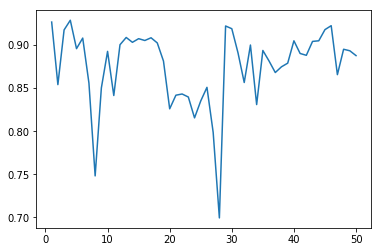

In [46]:
x_plot = list(range(1, len(test_accuracy) + 1))
x_plot = numpy.array(x_plot)
plt.plot(x_plot, test_accuracy)
plt.show()

In [50]:
classifier = MLPClassifier(activation = 'logistic', alpha = 0.01)
classifier.fit(x_train, y_train)

MLPClassifier(activation='logistic', alpha=0.01, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [54]:
pred = classifier.predict(x_train)
accuracy_score(pred, y_train)

0.9925438596491228

In [52]:
classifier2 = MLPClassifier(activation = 'logistic', alpha = 0.01, hidden_layer_sizes=(100, 50, 50))
classifier2.fit(x_train, y_train)

MLPClassifier(activation='logistic', alpha=0.01, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 50, 50), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [56]:
pred = classifier2.predict(x_test)
accuracy_score(pred, y_test)

0.9740441950192915